<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RL_A2C_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`A2C` = `Advantage Actor-Critic` 방식이고

`A3C` 에서 Asynchronous 대신 Synchronous 하게 바꾼 알고리즘이다.

(성능 plotting과 설명을 주석으로 처리한 코드는 맨 아래 셀의 `최종 코드`를 보면 된다. 오리지널 코드는 A3C 카트폴 파일과 마찬가지로 [github](https://github.com/seungeunrho/minimalRL/blob/master/a2c.py) 를 참조했다.)

보다 정확히는 여러 병렬 환경에서 동시에 경험을 수집한 후, 일정 업데이트 간격(여기서는 update_interval 만큼의 step)을 모아서 한 번에 업데이트를 수행하는 `batch A2C` 방법이다 (즉, 매 step마다 바로 업데이트를 하지 않고, 일정량의 데이터를 모아서 배치 단위로 모델 파라미터를 업데이트하는 구조):

In [1]:
# 주석 없는 오리지널 코드
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import numpy as np

# Hyperparameters
n_train_processes = 3
learning_rate = 0.0002
update_interval = 5
gamma = 0.98
max_train_steps = 60000
PRINT_INTERVAL = update_interval * 100

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc_pi = nn.Linear(256, 2)
        self.fc_v = nn.Linear(256, 1)

    def pi(self, x, softmax_dim=1):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

def worker(worker_id, master_end, worker_end):
    master_end.close()  # Forbid worker to use the master end for messaging
    env = gym.make('CartPole-v1')
    env.seed(worker_id)

    while True:
        cmd, data = worker_end.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            worker_end.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            worker_end.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            worker_end.send(ob)
        elif cmd == 'close':
            worker_end.close()
            break
        elif cmd == 'get_spaces':
            worker_end.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class ParallelEnv:
    def __init__(self, n_train_processes):
        self.nenvs = n_train_processes
        self.waiting = False
        self.closed = False
        self.workers = list()

        master_ends, worker_ends = zip(*[mp.Pipe() for _ in range(self.nenvs)])
        self.master_ends, self.worker_ends = master_ends, worker_ends

        for worker_id, (master_end, worker_end) in enumerate(zip(master_ends, worker_ends)):
            p = mp.Process(target=worker,
                           args=(worker_id, master_end, worker_end))
            p.daemon = True
            p.start()
            self.workers.append(p)

        # Forbid master to use the worker end for messaging
        for worker_end in worker_ends:
            worker_end.close()

    def step_async(self, actions):
        for master_end, action in zip(self.master_ends, actions):
            master_end.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [master_end.recv() for master_end in self.master_ends]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for master_end in self.master_ends:
            master_end.send(('reset', None))
        return np.stack([master_end.recv() for master_end in self.master_ends])

    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    def close(self):  # For clean up resources
        if self.closed:
            return
        if self.waiting:
            [master_end.recv() for master_end in self.master_ends]
        for master_end in self.master_ends:
            master_end.send(('close', None))
        for worker in self.workers:
            worker.join()
            self.closed = True

def test(step_idx, model):
    env = gym.make('CartPole-v1')
    score = 0.0
    done = False
    num_test = 10

    for _ in range(num_test):
        s = env.reset()
        while not done:
            prob = model.pi(torch.from_numpy(s).float(), softmax_dim=0)
            a = Categorical(prob).sample().numpy()
            s_prime, r, done, info = env.step(a)
            s = s_prime
            score += r
        done = False
    print(f"Step # :{step_idx}, avg score : {score/num_test:.1f}")

    env.close()

def compute_target(v_final, r_lst, mask_lst):
    G = v_final.reshape(-1)
    td_target = list()

    for r, mask in zip(r_lst[::-1], mask_lst[::-1]):
        G = r + gamma * G * mask
        td_target.append(G)

    return torch.tensor(td_target[::-1]).float()

if __name__ == '__main__':
    envs = ParallelEnv(n_train_processes)

    model = ActorCritic()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    step_idx = 0
    s = envs.reset()
    while step_idx < max_train_steps:
        s_lst, a_lst, r_lst, mask_lst = list(), list(), list(), list()
        for _ in range(update_interval):
            prob = model.pi(torch.from_numpy(s).float())
            a = Categorical(prob).sample().numpy()
            s_prime, r, done, info = envs.step(a)

            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r/100.0)
            mask_lst.append(1 - done)

            s = s_prime
            step_idx += 1

        s_final = torch.from_numpy(s_prime).float()
        v_final = model.v(s_final).detach().clone().numpy()
        td_target = compute_target(v_final, r_lst, mask_lst)

        td_target_vec = td_target.reshape(-1)
        s_vec = torch.tensor(s_lst).float().reshape(-1, 4)  # 4 == Dimension of state
        a_vec = torch.tensor(a_lst).reshape(-1).unsqueeze(1)
        advantage = td_target_vec - model.v(s_vec).reshape(-1)

        pi = model.pi(s_vec, softmax_dim=1)
        pi_a = pi.gather(1, a_vec).reshape(-1)
        loss = -(torch.log(pi_a) * advantage.detach()).mean() +\
            F.smooth_l1_loss(model.v(s_vec).reshape(-1), td_target_vec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step_idx % PRINT_INTERVAL == 0:
            test(step_idx, model)

    envs.close()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old s

Step # :500, avg score : 17.1
Step # :1000, avg score : 25.9
Step # :1500, avg score : 14.6
Step # :2000, avg score : 26.2
Step # :2500, avg score : 24.6
Step # :3000, avg score : 46.4
Step # :3500, avg score : 51.4
Step # :4000, avg score : 58.7
Step # :4500, avg score : 76.8
Step # :5000, avg score : 51.4
Step # :5500, avg score : 78.9
Step # :6000, avg score : 115.9
Step # :6500, avg score : 77.9
Step # :7000, avg score : 117.4
Step # :7500, avg score : 112.0
Step # :8000, avg score : 112.8
Step # :8500, avg score : 145.7
Step # :9000, avg score : 110.4
Step # :9500, avg score : 141.3
Step # :10000, avg score : 193.4
Step # :10500, avg score : 204.4
Step # :11000, avg score : 188.6
Step # :11500, avg score : 197.8
Step # :12000, avg score : 210.4
Step # :12500, avg score : 179.2
Step # :13000, avg score : 234.7
Step # :13500, avg score : 197.4
Step # :14000, avg score : 250.7
Step # :14500, avg score : 165.4
Step # :15000, avg score : 215.8
Step # :15500, avg score : 269.7
Step # :1

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Step # :500, avg score : 25.8
Step # :1000, avg score : 22.8
Step # :1500, avg score : 43.8
Step # :2000, avg score : 41.2
Step # :2500, avg score : 63.0
Step # :3000, avg score : 85.2
Step # :3500, avg score : 87.8
Step # :4000, avg score : 90.2
Step # :4500, avg score : 114.5
Step # :5000, avg score : 157.2
Step # :5500, avg score : 181.2
Step # :6000, avg score : 106.5
Step # :6500, avg score : 137.8
Step # :7000, avg score : 146.4
Step # :7500, avg score : 214.2
Step # :8000, avg score : 221.3
Step # :8500, avg score : 197.6
Step # :9000, avg score : 161.6
Step # :9500, avg score : 170.6
Step # :10000, avg score : 207.0
Step # :10500, avg score : 232.1
Step # :11000, avg score : 200.1
Step # :11500, avg score : 192.2
Step # :12000, avg score : 168.8
Step # :12500, avg score : 191.5
Step # :13000, avg score : 220.8
Step # :13500, avg score : 346.5
Step # :14000, avg score : 267.7
Step # :14500, avg score : 339.2
Step # :15000, avg score : 301.5
Step # :15500, avg score : 397.6
Step 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

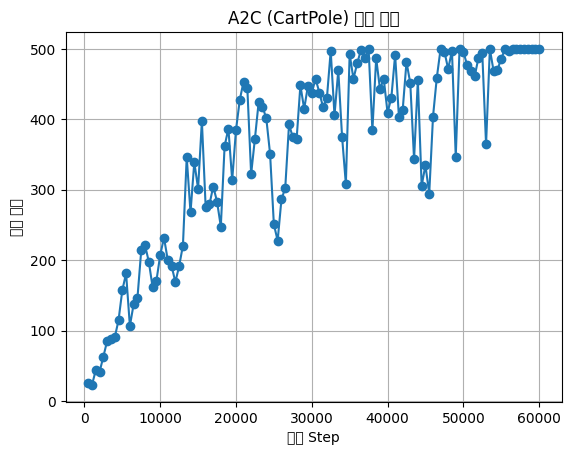

In [2]:
# 설명용 주석 많이 추가된 코드

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt  # 성능 plot 을 위해 matplotlib import

# 하이퍼파라미터 설정
n_train_processes = 3        # 학습에 사용할 환경 프로세스 수 (병렬 실행)
learning_rate = 0.0002       # 학습률
update_interval = 5          # 파라미터 업데이트 전까지의 step 수
gamma = 0.98                 # 할인 계수 (미래 보상에 대한 중요도)
max_train_steps = 60000      # 최대 학습 step 수
PRINT_INTERVAL = update_interval * 100  # 학습 중 평가를 출력할 간격

# Actor-Critic 신경망 모델 정의
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        # 입력 차원 4 (CartPole의 상태: 위치, 속도, 각도, 각속도) -> 은닉층 256
        self.fc1 = nn.Linear(4, 256)
        # 정책 네트워크 (action 선택 확률): 은닉층 256 -> 출력 2 (CartPole의 액션 수)
        self.fc_pi = nn.Linear(256, 2)
        # 가치 함수 네트워크: 은닉층 256 -> 출력 1 (상태의 가치)
        self.fc_v = nn.Linear(256, 1)

    # 정책 함수: 주어진 상태 x에 대해 액션의 확률 분포를 출력
    def pi(self, x, softmax_dim=1):
        x = F.relu(self.fc1(x))                # 은닉층에서 ReLU 활성화 함수 적용
        x = self.fc_pi(x)                      # 정책 네트워크 통과
        prob = F.softmax(x, dim=softmax_dim)     # 출력 값을 소프트맥스 함수를 사용해 확률 분포로 변환
        return prob

    # 가치 함수: 주어진 상태 x에 대해 상태의 가치를 출력
    def v(self, x):
        x = F.relu(self.fc1(x))                # 은닉층에서 ReLU 활성화 함수 적용
        v = self.fc_v(x)                       # 가치 함수 네트워크 통과
        return v

# 각 워커 프로세스에서 실행되는 함수
def worker(worker_id, master_end, worker_end):
    master_end.close()  # 워커가 master_end를 사용하지 못하도록 닫음
    env = gym.make('CartPole-v1')  # CartPole 환경 생성
    env.seed(worker_id)            # 워커마다 다른 시드를 부여하여 환경의 다양성 확보

    while True:
        # master에서 명령과 데이터를 수신
        cmd, data = worker_end.recv()
        if cmd == 'step':
            # 환경의 step 수행: data는 액션
            ob, reward, done, info = env.step(data)
            # 에피소드가 종료되면 환경을 리셋
            if done:
                ob = env.reset()
            # 결과를 master에 전송
            worker_end.send((ob, reward, done, info))
        elif cmd == 'reset':
            # 환경 리셋 후 초기 상태 전송
            ob = env.reset()
            worker_end.send(ob)
        elif cmd == 'reset_task':
            # reset_task 명령 처리 (일부 환경에서 사용)
            ob = env.reset_task()
            worker_end.send(ob)
        elif cmd == 'close':
            # 종료 명령 시 통신 채널을 닫고 반복문 종료
            worker_end.close()
            break
        elif cmd == 'get_spaces':
            # 환경의 observation_space와 action_space 정보를 전송
            worker_end.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

# 병렬 환경을 관리하기 위한 클래스 정의
class ParallelEnv:
    def __init__(self, n_train_processes):
        self.nenvs = n_train_processes  # 사용 환경 수
        self.waiting = False            # 현재 step 결과를 기다리는 상태인지 여부
        self.closed = False             # 환경이 종료되었는지 여부
        self.workers = list()           # 생성된 워커 프로세스 리스트

        # 각 프로세스와의 통신을 위한 Pipe 생성 (master end와 worker end로 분리)
        master_ends, worker_ends = zip(*[mp.Pipe() for _ in range(self.nenvs)])
        self.master_ends, self.worker_ends = master_ends, worker_ends

        # 각 환경에 대해 워커 프로세스를 생성하고 시작
        for worker_id, (master_end, worker_end) in enumerate(zip(master_ends, worker_ends)):
            p = mp.Process(target=worker,
                           args=(worker_id, master_end, worker_end))
            p.daemon = True  # 메인 프로세스 종료 시 자동 종료되도록 설정
            p.start()
            self.workers.append(p)

        # master에서는 worker_end를 사용하지 않으므로 모두 닫음
        for worker_end in worker_ends:
            worker_end.close()

    # 비동기적으로 각 환경에 액션을 보내 step 수행 요청
    def step_async(self, actions):
        for master_end, action in zip(self.master_ends, actions):
            master_end.send(('step', action))
        self.waiting = True

    # 각 환경의 step 결과를 기다려 수신
    def step_wait(self):
        results = [master_end.recv() for master_end in self.master_ends]
        self.waiting = False
        # 각 결과를 unpack하여 반환: 관측값, 보상, 종료 여부, 추가 정보
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    # 모든 환경을 리셋하는 함수
    def reset(self):
        for master_end in self.master_ends:
            master_end.send(('reset', None))
        # 각 환경의 초기 상태를 수신하여 스택으로 반환
        return np.stack([master_end.recv() for master_end in self.master_ends])

    # step_async와 step_wait를 묶어 동기적으로 step을 수행하는 함수
    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    # 환경 자원을 정리하는 함수
    def close(self):
        if self.closed:
            return
        if self.waiting:
            [master_end.recv() for master_end in self.master_ends]
        # 각 워커에 종료 명령 전송
        for master_end in self.master_ends:
            master_end.send(('close', None))
        # 모든 워커 프로세스가 종료될 때까지 대기
        for worker in self.workers:
            worker.join()
        self.closed = True

# 현재 모델을 평가하는 함수 (테스트 환경에서 실행)
def test(step_idx, model):
    env = gym.make('CartPole-v1')
    score = 0.0   # 총 보상 합계
    num_test = 10  # 테스트 에피소드 수

    for _ in range(num_test):
        s = env.reset()  # 환경 초기화 및 초기 상태 얻기
        done = False   # 에피소드 종료 플래그 초기화
        while not done:
            # 현재 상태를 텐서로 변환하여 모델의 정책 함수에 넣어 확률 분포를 얻음
            prob = model.pi(torch.from_numpy(s).float(), softmax_dim=0)
            # Categorical 분포에서 액션 샘플링
            a = Categorical(prob).sample().numpy()
            # 선택된 액션으로 환경 step 수행
            s, r, done, info = env.step(a)
            score += r  # 보상 누적
    avg_score = score / num_test  # 평균 보상 계산
    print(f"Step # :{step_idx}, avg score : {avg_score:.1f}")
    env.close()
    return avg_score  # 평균 보상을 반환하여 plot에 기록

if __name__ == '__main__':
    # 병렬 환경 생성
    envs = ParallelEnv(n_train_processes)

    # Actor-Critic 모델 및 옵티마이저 초기화
    model = ActorCritic()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 평가 결과 기록을 위한 리스트 초기화
    eval_steps = []   # 평가를 수행한 학습 step 기록
    eval_scores = []  # 해당 step에서의 평균 보상 기록

    step_idx = 0  # 전체 학습 스텝 수를 카운트
    s = envs.reset()  # 모든 환경을 리셋하여 초기 상태들을 얻음

    # 최대 학습 스텝까지 반복
    while step_idx < max_train_steps:
        # 업데이트 주기 동안의 데이터 저장용 리스트들
        s_lst, a_lst, r_lst, mask_lst = list(), list(), list(), list()
        for _ in range(update_interval):
            # 현재 상태 s를 텐서로 변환하여 정책 함수를 통해 액션 확률 분포 계산
            prob = model.pi(torch.from_numpy(s).float())
            # 확률 분포로부터 액션 샘플링 (각 환경별로 액션 선택)
            a = Categorical(prob).sample().numpy()
            # 선택된 액션들을 각 병렬 환경에서 step 수행
            s_prime, r, done, info = envs.step(a)

            # 현재 상태, 선택된 액션, (보상은 100.0으로 나누어 스케일 조정), 그리고 mask (에피소드 종료 여부) 저장
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r/100.0)
            mask_lst.append(1 - done)

            s = s_prime  # 다음 step을 위해 상태 업데이트
            step_idx += 1

        # 마지막 상태에서의 가치 함수 추정 (학습 시 gradient 계산 제외를 위해 detach)
        s_final = torch.from_numpy(s_prime).float()
        v_final = model.v(s_final).detach().clone().numpy()
        # TD 타깃 계산
        td_target = compute_target(v_final, r_lst, mask_lst)

        # 저장된 데이터를 텐서 형태로 변환 및 재구조화
        td_target_vec = td_target.reshape(-1)
        s_vec = torch.tensor(s_lst).float().reshape(-1, 4)  # 상태 벡터: 각 상태의 차원은 4
        a_vec = torch.tensor(a_lst).reshape(-1).unsqueeze(1)  # 액션 벡터 (모양 맞추기)
        # advantage 계산: (TD 타깃 - 가치 함수 예측)
        advantage = td_target_vec - model.v(s_vec).reshape(-1)

        # 모델의 정책 네트워크로부터 확률 분포 계산 및 선택된 액션의 확률만 추출
        pi = model.pi(s_vec, softmax_dim=1)
        pi_a = pi.gather(1, a_vec).reshape(-1)
        # 손실 함수 계산
        # 정책 손실: 로그 확률에 advantage를 곱한 값을 최소화 (- 기호로 maximization 효과)
        # 가치 손실: Smooth L1 Loss를 사용하여 상태 가치와 TD 타깃의 차이를 최소화
        loss = -(torch.log(pi_a) * advantage.detach()).mean() + \
               F.smooth_l1_loss(model.v(s_vec).reshape(-1), td_target_vec)

        # 경사 초기화, 역전파 수행, 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 일정 간격마다 모델 성능 평가 후 결과 기록
        if step_idx % PRINT_INTERVAL == 0:
            avg_score = test(step_idx, model)
            eval_steps.append(step_idx)
            eval_scores.append(avg_score)

    # 학습 종료 후 환경 자원 정리
    envs.close()

    # 학습 동안 기록된 성능 결과를 plot 함 (학습 step 대비 평균 보상)
    plt.figure()
    plt.plot(eval_steps, eval_scores, marker='o')
    plt.xlabel("Training Step")
    plt.ylabel("Average Reward")
    plt.title("A2C (CartPole) Performance")
    plt.grid(True)
    plt.show()

# TD 타깃(Temporal Difference Target)을 계산하는 함수
def compute_target(v_final, r_lst, mask_lst):
    # v_final : 마지막 상태의 가치, r_lst : 보상 리스트, mask_lst : 에피소드 종료 여부 (done에 따른 mask)
    G = v_final.reshape(-1)
    td_target = list()

    # 보상과 mask 리스트를 역순으로 순회하며 TD 타깃 계산 (할인 보상 누적)
    for r, mask in zip(r_lst[::-1], mask_lst[::-1]):
        G = r + gamma * G * mask  # 에피소드가 종료된 경우 mask가 0이 되어 더 이상 보상이 누적되지 않음
        td_target.append(G)

    # 계산된 타깃을 원래 순서로 뒤집어 텐서로 반환
    return torch.tensor(td_target[::-1]).float()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recomme

Step # :500, avg score : 24.1
Step # :1000, avg score : 25.8
Step # :1500, avg score : 29.8
Step # :2000, avg score : 23.3
Step # :2500, avg score : 38.5
Step # :3000, avg score : 42.2
Step # :3500, avg score : 65.3
Step # :4000, avg score : 83.2
Step # :4500, avg score : 92.0
Step # :5000, avg score : 129.9
Step # :5500, avg score : 116.2
Step # :6000, avg score : 145.9
Step # :6500, avg score : 132.7
Step # :7000, avg score : 135.2
Step # :7500, avg score : 162.2
Step # :8000, avg score : 153.2
Step # :8500, avg score : 159.2
Step # :9000, avg score : 177.0
Step # :9500, avg score : 154.4
Step # :10000, avg score : 223.7
Step # :10500, avg score : 217.8
Step # :11000, avg score : 176.4
Step # :11500, avg score : 178.5
Step # :12000, avg score : 255.3
Step # :12500, avg score : 215.2
Step # :13000, avg score : 224.7
Step # :13500, avg score : 268.8
Step # :14000, avg score : 302.9
Step # :14500, avg score : 252.6
Step # :15000, avg score : 247.9
Step # :15500, avg score : 280.9
Step #

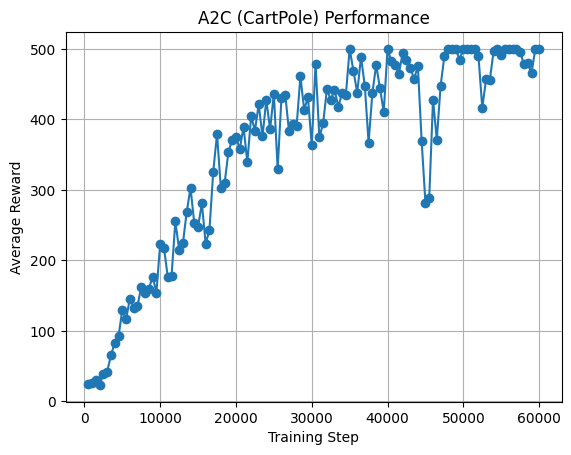

In [2]:
# 추가로 성능 plotting 을 구현하는 파트를 추가한 코드
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt  # 성능 plot 을 위해 matplotlib import

# 하이퍼파라미터 설정
n_train_processes = 3        # 학습에 사용할 환경 프로세스 수 (병렬 실행)
learning_rate = 0.0002       # 학습률
update_interval = 5          # 파라미터 업데이트 전까지의 step 수
gamma = 0.98                 # 할인 계수 (미래 보상에 대한 중요도)
max_train_steps = 60000      # 최대 학습 step 수
PRINT_INTERVAL = update_interval * 100  # 학습 중 평가를 출력할 간격

# Actor-Critic 신경망 모델 정의
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        # 입력 차원 4 (CartPole의 상태: 위치, 속도, 각도, 각속도) -> 은닉층 256
        self.fc1 = nn.Linear(4, 256)
        # 정책 네트워크 (action 선택 확률): 은닉층 256 -> 출력 2 (CartPole의 액션 수)
        self.fc_pi = nn.Linear(256, 2)
        # 가치 함수 네트워크: 은닉층 256 -> 출력 1 (상태의 가치)
        self.fc_v = nn.Linear(256, 1)

    # 정책 함수: 주어진 상태 x에 대해 액션의 확률 분포를 출력
    def pi(self, x, softmax_dim=1):
        x = F.relu(self.fc1(x))                # 은닉층에서 ReLU 활성화 함수 적용
        x = self.fc_pi(x)                      # 정책 네트워크 통과
        prob = F.softmax(x, dim=softmax_dim)     # 출력 값을 소프트맥스 함수를 사용해 확률 분포로 변환
        return prob

    # 가치 함수: 주어진 상태 x에 대해 상태의 가치를 출력
    def v(self, x):
        x = F.relu(self.fc1(x))                # 은닉층에서 ReLU 활성화 함수 적용
        v = self.fc_v(x)                       # 가치 함수 네트워크 통과
        return v

# 각 워커 프로세스에서 실행되는 함수
def worker(worker_id, master_end, worker_end):
    master_end.close()  # 워커가 master_end를 사용하지 못하도록 닫음
    env = gym.make('CartPole-v1')  # CartPole 환경 생성
    env.seed(worker_id)            # 워커마다 다른 시드를 부여하여 환경의 다양성 확보

    while True:
        # master에서 명령과 데이터를 수신
        cmd, data = worker_end.recv()
        if cmd == 'step':
            # 환경의 step 수행: data는 액션
            ob, reward, done, info = env.step(data)
            # 에피소드가 종료되면 환경을 리셋
            if done:
                ob = env.reset()
            # 결과를 master에 전송
            worker_end.send((ob, reward, done, info))
        elif cmd == 'reset':
            # 환경 리셋 후 초기 상태 전송
            ob = env.reset()
            worker_end.send(ob)
        elif cmd == 'reset_task':
            # reset_task 명령 처리 (일부 환경에서 사용)
            ob = env.reset_task()
            worker_end.send(ob)
        elif cmd == 'close':
            # 종료 명령 시 통신 채널을 닫고 반복문 종료
            worker_end.close()
            break
        elif cmd == 'get_spaces':
            # 환경의 observation_space와 action_space 정보를 전송
            worker_end.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

# 병렬 환경을 관리하기 위한 클래스 정의
class ParallelEnv:
    def __init__(self, n_train_processes):
        self.nenvs = n_train_processes  # 사용 환경 수
        self.waiting = False            # 현재 step 결과를 기다리는 상태인지 여부
        self.closed = False             # 환경이 종료되었는지 여부
        self.workers = list()           # 생성된 워커 프로세스 리스트

        # 각 프로세스와의 통신을 위한 Pipe 생성 (master end와 worker end로 분리)
        master_ends, worker_ends = zip(*[mp.Pipe() for _ in range(self.nenvs)])
        self.master_ends, self.worker_ends = master_ends, worker_ends

        # 각 환경에 대해 워커 프로세스를 생성하고 시작
        for worker_id, (master_end, worker_end) in enumerate(zip(master_ends, worker_ends)):
            p = mp.Process(target=worker,
                           args=(worker_id, master_end, worker_end))
            p.daemon = True  # 메인 프로세스 종료 시 자동 종료되도록 설정
            p.start()
            self.workers.append(p)

        # master에서는 worker_end를 사용하지 않으므로 모두 닫음
        for worker_end in worker_ends:
            worker_end.close()

    # 비동기적으로 각 환경에 액션을 보내 step 수행 요청
    def step_async(self, actions):
        for master_end, action in zip(self.master_ends, actions):
            master_end.send(('step', action))
        self.waiting = True

    # 각 환경의 step 결과를 기다려 수신
    def step_wait(self):
        results = [master_end.recv() for master_end in self.master_ends]
        self.waiting = False
        # 각 결과를 unpack하여 반환: 관측값, 보상, 종료 여부, 추가 정보
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    # 모든 환경을 리셋하는 함수
    def reset(self):
        for master_end in self.master_ends:
            master_end.send(('reset', None))
        # 각 환경의 초기 상태를 수신하여 스택으로 반환
        return np.stack([master_end.recv() for master_end in self.master_ends])

    # step_async와 step_wait를 묶어 동기적으로 step을 수행하는 함수
    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()

    # 환경 자원을 정리하는 함수
    def close(self):
        if self.closed:
            return
        if self.waiting:
            [master_end.recv() for master_end in self.master_ends]
        # 각 워커에 종료 명령 전송
        for master_end in self.master_ends:
            master_end.send(('close', None))
        # 모든 워커 프로세스가 종료될 때까지 대기
        for worker in self.workers:
            worker.join()
        self.closed = True

# 현재 모델을 평가하는 함수 (테스트 환경에서 실행)
def test(step_idx, model):
    env = gym.make('CartPole-v1')
    score = 0.0   # 총 보상 합계
    num_test = 10  # 테스트 에피소드 수

    for _ in range(num_test):
        s = env.reset()  # 환경 초기화 및 초기 상태 얻기
        done = False   # 에피소드 종료 플래그 초기화
        while not done:
            # 현재 상태를 텐서로 변환하여 모델의 정책 함수에 넣어 확률 분포를 얻음
            prob = model.pi(torch.from_numpy(s).float(), softmax_dim=0)
            # Categorical 분포에서 액션 샘플링
            a = Categorical(prob).sample().numpy()
            # 선택된 액션으로 환경 step 수행
            s, r, done, info = env.step(a)
            score += r  # 보상 누적
    avg_score = score / num_test  # 평균 보상 계산
    print(f"Step # :{step_idx}, avg score : {avg_score:.1f}")
    env.close()
    return avg_score  # 평균 보상을 반환하여 plot에 기록

# TD 타깃(Temporal Difference Target)을 계산하는 함수
def compute_target(v_final, r_lst, mask_lst):
    # v_final : 마지막 상태의 가치, r_lst : 보상 리스트, mask_lst : 에피소드 종료 여부 (done에 따른 mask)
    G = v_final.reshape(-1)
    td_target = list()

    # 보상과 mask 리스트를 역순으로 순회하며 TD 타깃 계산 (할인 보상 누적)
    for r, mask in zip(r_lst[::-1], mask_lst[::-1]):
        G = r + gamma * G * mask  # 에피소드가 종료된 경우 mask가 0이 되어 더 이상 보상이 누적되지 않음
        td_target.append(G)

    # 계산된 타깃을 원래 순서로 뒤집어 텐서로 반환
    return torch.tensor(td_target[::-1]).float()

if __name__ == '__main__':
    # 병렬 환경 생성
    envs = ParallelEnv(n_train_processes)

    # Actor-Critic 모델 및 옵티마이저 초기화
    model = ActorCritic()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 평가 결과 기록을 위한 리스트 초기화
    eval_steps = []   # 평가를 수행한 학습 step 기록
    eval_scores = []  # 해당 step에서의 평균 보상 기록

    step_idx = 0  # 전체 학습 스텝 수를 카운트
    s = envs.reset()  # 모든 환경을 리셋하여 초기 상태들을 얻음

    # 최대 학습 스텝까지 반복
    while step_idx < max_train_steps:
        # 업데이트 주기 동안의 데이터 저장용 리스트들
        s_lst, a_lst, r_lst, mask_lst = list(), list(), list(), list()
        for _ in range(update_interval):
            # 현재 상태 s를 텐서로 변환하여 정책 함수를 통해 액션 확률 분포 계산
            prob = model.pi(torch.from_numpy(s).float())
            # 확률 분포로부터 액션 샘플링 (각 환경별로 액션 선택)
            a = Categorical(prob).sample().numpy()
            # 선택된 액션들을 각 병렬 환경에서 step 수행
            s_prime, r, done, info = envs.step(a)

            # 현재 상태, 선택된 액션, (보상은 100.0으로 나누어 스케일 조정), 그리고 mask (에피소드 종료 여부) 저장
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r/100.0)
            mask_lst.append(1 - done)

            s = s_prime  # 다음 step을 위해 상태 업데이트
            step_idx += 1

        # 마지막 상태에서의 가치 함수 추정 (학습 시 gradient 계산 제외를 위해 detach)
        s_final = torch.from_numpy(s_prime).float()
        v_final = model.v(s_final).detach().clone().numpy()
        # TD 타깃 계산
        td_target = compute_target(v_final, r_lst, mask_lst)

        # 저장된 데이터를 텐서 형태로 변환 및 재구조화
        td_target_vec = td_target.reshape(-1)
        s_vec = torch.tensor(s_lst).float().reshape(-1, 4)  # 상태 벡터: 각 상태의 차원은 4
        a_vec = torch.tensor(a_lst).reshape(-1).unsqueeze(1)  # 액션 벡터 (모양 맞추기)
        # advantage 계산: (TD 타깃 - 가치 함수 예측)
        advantage = td_target_vec - model.v(s_vec).reshape(-1)

        # 모델의 정책 네트워크로부터 확률 분포 계산 및 선택된 액션의 확률만 추출
        pi = model.pi(s_vec, softmax_dim=1)
        pi_a = pi.gather(1, a_vec).reshape(-1)
        # 손실 함수 계산
        # 정책 손실: 로그 확률에 advantage를 곱한 값을 최소화 (- 기호로 maximization 효과)
        # 가치 손실: Smooth L1 Loss를 사용하여 상태 가치와 TD 타깃의 차이를 최소화
        loss = -(torch.log(pi_a) * advantage.detach()).mean() + \
               F.smooth_l1_loss(model.v(s_vec).reshape(-1), td_target_vec)

        # 경사 초기화, 역전파 수행, 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 일정 간격마다 모델 성능 평가 후 결과 기록
        if step_idx % PRINT_INTERVAL == 0:
            avg_score = test(step_idx, model)
            eval_steps.append(step_idx)
            eval_scores.append(avg_score)

    # 학습 종료 후 환경 자원 정리
    envs.close()

    # 학습 동안 기록된 성능 결과를 plot 함 (학습 step 대비 평균 보상)
    plt.figure()
    plt.plot(eval_steps, eval_scores, marker='o')
    plt.xlabel("Training Step")
    plt.ylabel("Average Reward")
    plt.title("A2C (CartPole) Performance")
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Step # :500, avg score : 16.0
Step # :1000, avg score : 15.3
Step # :1500, avg score : 24.1
Step # :2000, avg score : 20.0
Step # :2500, avg score : 26.6
Step # :3000, avg score : 41.9
Step # :3500, avg score : 32.5
Step # :4000, avg score : 41.6
Step # :4500, avg score : 62.4
Step # :5000, avg score : 87.4
Step # :5500, avg score : 96.3
Step # :6000, avg score : 110.2
Step # :6500, avg score : 84.3
Step # :7000, avg score : 99.0
Step # :7500, avg score : 79.7
Step # :8000, avg score : 114.3
Step # :8500, avg score : 96.7
Step # :9000, avg score : 148.6
Step # :9500, avg score : 145.1
Step # :10000, avg score : 165.0
Step # :10500, avg score : 170.8
Step # :11000, avg score : 96.4
Step # :11500, avg score : 233.2
Step # :12000, avg score : 156.9
Step # :12500, avg score : 156.9
Step # :13000, avg score : 218.4
Step # :13500, avg score : 229.3
Step # :14000, avg score : 226.2
Step # :14500, avg score : 150.2
Step # :15000, avg score : 228.4
Step # :15500, avg score : 274.3
Step # :16000

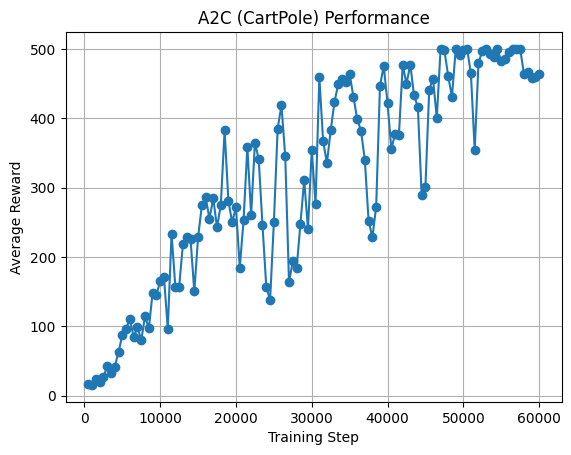

In [6]:
# (최종 코드)
# 긴 설명을 위한 많은 주석들과 성능 plotting 구현을 추가한 코드

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt  # 성능 plot

# 하이퍼파라미터 설정
n_train_processes = 3        # 학습에 사용할 환경 프로세스 수 (병렬 실행)
learning_rate = 0.0002
update_interval = 5          # 파라미터 업데이트 전까지의 step 수
gamma = 0.98
max_train_steps = 60000
PRINT_INTERVAL = update_interval * 100  # 학습 중 평가를 출력할 간격

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc_pi = nn.Linear(256, 2)
        self.fc_v = nn.Linear(256, 1)

    # 정책 함수: 주어진 상태 x에 대해 액션의 확률 분포를 출력
    def pi(self, x, softmax_dim=1):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)               # 정책 네트워크 통과
        prob = F.softmax(x, dim=softmax_dim)  # 출력 값을 소프트맥스 함수를 사용해 확률 분포로 변환
        return prob

    # 가치 함수: 주어진 상태 x에 대해 상태의 가치를 출력
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)                # 가치 함수 네트워크 통과
        return v
"""
worker 함수는 A2C 구조에서 병렬로 환경과 상호작용하여 경험 데이터를 효율적으로
수집하는 역할을 담당한다. 이를 통해 메인 프로세스는 다양한 환경으로부터 동시에 데이터를
받아, 배치 업데이트 방식을 통해 모델 파라미터를 안정적으로 학습할 수 있게 된다.

master_end는 메인 프로세스(또는 부모 프로세스)가 사용하는 통신 Pipe의 한쪽 끝이다.
master_end.close()를 호출하면, 워커 프로세스가 메인 프로세스의 통신 끝을
사용하지 못하도록 막는다. 이렇게 함으로써 각 프로세스는 자신에게 할당된 파이프 끝
(여기서는 worker_end)만을 사용하여 통신하고, 서로의 역할이 명확하게 구분된다.

worker_end는 worker 함수가 메인 프로세스와의 통신에 사용하는 파이프의 끝이다.
워커는 worker_end.recv() 호출을 통해 메인 프로세스로부터 명령과 관련 데이터를
수신받는다. 작업을 수행한 후, worker_end.send(...)를 사용하여 결과
(예: 상태, 보상, 종료 여부 등)를 메인 프로세스로 전송한다.
독립적인 환경 실행: 각 워커는 개별적으로 환경과 상호작용하며, 메인 프로세스와 오직
worker_end를 통해서만 데이터를 주고받는다.

(메인-워커 간 통신의 기반)
메인 프로세스는 master_end를 통해 워커에게 명령(예: 'step', 'reset', 'close' 등)을
보내고, 워커는 worker_end를 통해 응답을 보낸다.

recv()는 블로킹 함수로, 메시지가 도착할 때까지 호출된 프로세스를 block한다.
즉, 메인 프로세스가 메시지를 보내기 전까지 worker는 대기 상태에 있게 된다.

"""
# 각 워커 프로세스에서 실행되는 함수
def worker(worker_id, master_end, worker_end):
    master_end.close()  # 워커가 master_end를 사용하지 못하도록 닫아, worker가 오직 worker_end를 통해서만 메인 프로세스와 통신하도록 한다.
    env = gym.make('CartPole-v1')
    env.seed(worker_id) # 워커마다 다른 시드를 부여하여 (학습시) 환경의 다양성 확보

    while True:
        cmd, data = worker_end.recv() # master에서 명령과 데이터(액션 정보)를 수신

        if cmd == 'step': # 환경의 step 수행: data는 액션
            ob, reward, done, info = env.step(data) # ob는 A3C의 next_state 또는 s_prime와 같음

            if done: # 에피소드가 종료되면 환경을 리셋
                ob = env.reset()
            worker_end.send((ob, reward, done, info)) # 결과를 master에(메인 프로세스에) 전송
        elif cmd == 'reset': # 환경 리셋 후 초기 상태 전송
            ob = env.reset()
            worker_end.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task() # reset_task 명령이 있을 경우 처리 (일부 환경에서 다른 리셋 함수가 있을 때 사용)
            worker_end.send(ob)
        elif cmd == 'close': # 종료 명령 시 통신 채널을 닫고 반복문 종료
            worker_end.close()
            break
        elif cmd == 'get_spaces': # 환경의 observation_space와 action_space 정보를 전송
            worker_end.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError # 알 수 없는 명령이 들어오면 에러 발생
"""
zip(*[mp.Pipe() for _ in range(self.nenvs)]) 에서 *는 unpacking을 수행한다.
zip(*list_of_tuples)는 리스트에 들어 있는 각 튜플의 동일한 인덱스끼리 묶어
새로운 튜플들을 만든다. 즉, master_end들은 master_end끼리 묶고, worker_end들은
worker end끼리 묶는다.

daemon 프로세스는 백그라운드에서 실행되는 프로세스를 의미하며,
메인 프로세스가 종료되면 자동으로 함께 종료된다. p.daemon = True 로 설정하면,
만약 메인 프로세스가 종료되었을 때 워커 프로세스(데몬 프로세스)도 강제로 종료된다.
이는 자식 프로세스가 메인 프로세스의 종료로 인해 고아 프로세스가 되는 것을 방지하고,
프로그램이 깔끔하게 종료되도록 돕는다.



"""
# 병렬 환경을 관리하기 위한 클래스 정의
class ParallelEnv:
    def __init__(self, n_train_processes):
        self.nenvs = n_train_processes  # 사용 환경 수
        self.waiting = False            # 현재 step 결과를 기다리는 상태인지 여부
        self.closed = False             # 환경이 종료되었는지 여부
        self.workers = list()           # 생성된 워커 프로세스 리스트

        # 각 프로세스와의 통신을 위한 Pipe 생성 (master end와 worker end로 분리)
        master_ends, worker_ends = zip(*[mp.Pipe() for _ in range(self.nenvs)])
        self.master_ends, self.worker_ends = master_ends, worker_ends

        # 각 환경에 대해 워커 프로세스를 생성하고 시작
        for worker_id, (master_end, worker_end) in enumerate(zip(master_ends, worker_ends)):
            p = mp.Process(target=worker,
                           args=(worker_id, master_end, worker_end))
            p.daemon = True  # 메인 프로세스 종료 시 자동 종료되도록 설정
            p.start() # 생성된 프로세스를 시작하여, worker 함수가 메인 프로세스와 병렬로 실행되게 함
            self.workers.append(p) # 나중에 환경을 종료할 때(close() 메서드 등) 모든 워커 프로세스에 접근하여 적절히 종료(join)할 수 있다.

        # master에서는 worker_end를 사용하지 않으므로 모두 닫음
        for worker_end in worker_ends:
            worker_end.close()

    # 비동기적으로 각 환경에 액션을 보내 step 수행 요청 (동시에 여러 환경에서 액션을 실행하도록 함: 병렬 처리)
    def step_async(self, actions):
        for master_end, action in zip(self.master_ends, actions):
            master_end.send(('step', action))
        # 액션 전송 후 결과를 기다리는 상태로 플래그를 설정
        self.waiting = True

    # 각 환경의 step 결과(각 워커 환경에서 실행한 액션의 결과)를 기다려 수신: 모든 워커 환경의 결과를 동기적으로 수집하여, 학습에 필요한 데이터를 한 번에 모은다.
    def step_wait(self):
        results = [master_end.recv() for master_end in self.master_ends]
        self.waiting = False
        # 각 결과를 unpack하여 반환: 관측값(next_state), 보상, 종료 여부, 추가 정보
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    # 모든 환경을 리셋하는 함수
    def reset(self):
        for master_end in self.master_ends:
            master_end.send(('reset', None))
        # 각 환경의 초기 상태를 수신하여 스택으로 반환
        return np.stack([master_end.recv() for master_end in self.master_ends])

    # step_async와 step_wait를 묶어 동기적으로 step을 수행하는 함수
    def step(self, actions):
        # 메인 프로세스가 각 환경(워커)에게 실행할 액션을 동시에 전송
        self.step_async(actions)
        return self.step_wait()

    # 환경 자원을 정리하는 함수: 병렬 환경에서 사용된 모든 통신 채널과 워커 프로세스를 안전하게 종료하여 자원을 해제
    def close(self):
        # 이미 환경이 종료된 상태라면, 더 이상 아무 작업도 수행하지 않는다.
        if self.closed:
            return
        # 이전에 액션을 전송한 후 결과를 기다리고 있는 상태(self.waiting가 True)라면, 해당 결과(각 master_end에서 대기 중인 메시지)를 모두 수신하여 통신 채널을 정리
        if self.waiting:
            [master_end.recv() for master_end in self.master_ends]
        # 각 워커에 종료 명령 전송
        for master_end in self.master_ends:
            master_end.send(('close', None))
        # 모든 워커 프로세스가 종료될 때까지 대기
        for worker in self.workers:
            worker.join()
            self.closed = True

# 현재 모델을 평가하는 함수 (테스트 환경에서 실행)
def test(step_idx, model):
    env = gym.make('CartPole-v1')
    score = 0.0   # 총 보상 합계
    # done = False
    num_test = 10  # 테스트 에피소드 수

    for _ in range(num_test):
        s = env.reset()
        done = False # 에피소드 종료 플래그 초기화
        while not done:
            # 현재 상태를 텐서로 변환하여 모델의 정책 함수에 넣어 확률 분포를 얻음
            prob = model.pi(torch.from_numpy(s).float(), softmax_dim=0)
            # Categorical 분포에서 액션 샘플링
            a = Categorical(prob).sample().numpy()
            s_prime, r, done, info = env.step(a) # 선택된 액션으로 환경 step 수행
            s = s_prime  # 다음 상태 업데이트
            score += r  # 보상 누적
        # done = False  # 다음 에피소드를 위해 done 플래그 초기화
    avg_score = score / num_test
    print(f"Step # :{step_idx}, avg score : {avg_score:.1f}")
    env.close()

    return avg_score

# TD 타깃(Temporal Difference Target)을 계산하는 함수
def compute_target(v_final, r_lst, mask_lst):
    # v_final : 마지막 상태의 가치, r_lst : 보상 리스트, mask_lst : 에피소드 종료 여부 (done에 따른 mask)
    G = v_final.reshape(-1)
    td_target = list()

    # 보상과 mask 리스트를 역순으로 순회하며 TD 타깃 계산 (할인 보상 누적)
    for r, mask in zip(r_lst[::-1], mask_lst[::-1]):
        G = r + gamma * G * mask  # 에피소드가 종료된 경우 mask가 0이 되어 더 이상 보상이 누적되지 않음
        td_target.append(G)

    # 계산된 타깃을 원래 순서로 뒤집어 텐서로 반환
    return torch.tensor(td_target[::-1]).float()

# 메인 함수: 학습 루프를 실행
if __name__ == '__main__':
    envs = ParallelEnv(n_train_processes)

    model = ActorCritic() # Actor-Critic 구조의 신경망 모델을 생성
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 평가 결과 기록을 위한 리스트 초기화
    eval_steps = []   # 평가를 수행한 학습 step 기록
    eval_scores = []  # 해당 step에서의 평균 보상 기록

    step_idx = 0  # 전체 학습 스텝 수를 카운트
    s = envs.reset()

    # 학습 루프
    while step_idx < max_train_steps:
        s_lst, a_lst, r_lst, mask_lst = list(), list(), list(), list()
        # 각 워커 환경에서 데이터 수집
        for _ in range(update_interval):
            prob = model.pi(torch.from_numpy(s).float())
            a = Categorical(prob).sample().numpy()
            s_prime, r, done, info = envs.step(a) # a는 메인 프로세스가 현재 상태에서 선택한 액션 / envs.step(a) 호출로 모든 병렬 환경에서 액션이 실행되고, 그 결과가 모여 반환된다.

            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r/100.0)
            mask_lst.append(1 - done)

            s = s_prime  # 다음 step을 위해 상태 업데이트
            step_idx += 1

        # 마지막 상태에서의 가치 함수 추정 (학습 시 gradient 계산 제외를 위해 detach)
        s_final = torch.from_numpy(s_prime).float()
        v_final = model.v(s_final).detach().clone().numpy()
        td_target = compute_target(v_final, r_lst, mask_lst)

        # 저장된 데이터를 텐서 형태로 변환 및 재구조화
        td_target_vec = td_target.reshape(-1)
        s_vec = torch.tensor(s_lst).float().reshape(-1, 4)  # 상태 벡터: 각 상태의 차원은 4
        a_vec = torch.tensor(a_lst).reshape(-1).unsqueeze(1)  # 액션 벡터 (모양 맞추기)
        # advantage 계산: (TD 타깃 - 가치 함수 예측)
        advantage = td_target_vec - model.v(s_vec).reshape(-1)

        # 모델의 정책 네트워크로부터 확률 분포 계산 및 선택된 액션의 확률만 추출
        pi = model.pi(s_vec, softmax_dim=1)
        pi_a = pi.gather(1, a_vec).reshape(-1)
        # 손실 함수 계산
        # 정책 손실: 로그 확률에 advantage를 곱한 값을 최소화 (- 기호로 maximization 효과)
        # 가치 손실: Smooth L1 Loss를 사용하여 상태 가치와 TD 타깃의 차이를 최소화
        loss = -(torch.log(pi_a) * advantage.detach()).mean() + \
            F.smooth_l1_loss(model.v(s_vec).reshape(-1), td_target_vec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        """ (오리지널 코드)
        아래처럼 plotting에 활용하기 위해 수정

        # 일정 간격마다 모델 성능 평가
        if step_idx % PRINT_INTERVAL == 0:
            test(step_idx, model)
        """

        # 일정 간격마다 모델 성능 평가 후 결과 기록
        if step_idx % PRINT_INTERVAL == 0:
            avg_score = test(step_idx, model)
            eval_steps.append(step_idx)
            eval_scores.append(avg_score)

    envs.close()

    # 학습 동안 기록된 성능 결과를 plot 함 (학습 step 대비 평균 보상)
    plt.figure()
    plt.plot(eval_steps, eval_scores, marker='o')
    plt.xlabel("Training Step")
    plt.ylabel("Average Reward")
    plt.title("A2C (CartPole) Performance")
    plt.grid(True)
    plt.show()